In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress when moving to script: 
%matplotlib inline

Reading in the data:

In [2]:
usa = gpd.read_file('../data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
mobility_data = pd.read_csv('../data/2020_US_Region_Mobility_Report.csv')

Ignoring non-states:

In [3]:
states_to_ignore = ['Puerto Rico', 'American Samoa', 'United States Virgin Islands',
                    'Guam', 'Commonwealth of the Northern Mariana Islands']

strictly_states = usa[~usa['NAME'].isin(states_to_ignore)]

Converting to datetime:

In [4]:
mobility_data['date'] = pd.to_datetime(mobility_data['date'])

The functions to normalize the values, get state-level mobility data, and plotting it:

In [25]:
def norm_function(value, max_val, min_val):
    normed = float(value - min_val) / (max_val - min_val)
    return normed

# Generating a dictionary of each state, and the degree of lockdown - 1 is the highest, 0 is the lowest:
def get_mobility_data(input_date, metric='retail_and_recreation_percent_change_from_baseline'):
    # Getting just the states:
    date_subset = mobility_data[mobility_data['date'] == input_date]
    no_counties = date_subset[~date_subset['sub_region_2'].notna()]
    only_states = no_counties[no_counties['sub_region_1'].notna()]
    
    # Scaling the column of interest between 0 and 1:
    all_ratings = list(only_states[metric])
    all_states = [item.strip('US-') for item in list(only_states['iso_3166_2_code'])]
    min_val = np.min(all_ratings)
    max_val = np.max(all_ratings)
    normed_ratings = [1 - norm_function(item, max_val, min_val) for item in all_ratings]
    
    # Making a dictionary with each state and its normed value:
    normed_dict_w_states = {all_states[idx] : item for idx, item in enumerate(normed_ratings)}
    
    return normed_dict_w_states

# Preparing the colormap:
cmap = plt.cm.get_cmap('RdBu')

# Plotting data that show the degree to which a state is locked down:
def plotting_states_continuum(state_dict):
    fig, ax = plt.subplots(figsize=(30,30))
    # Plotting all the states that are listed one color:
    for each_state in state_dict.keys():
        temp_color_val = (state_dict[each_state] * 200) - 100
        temp_color = cmap(temp_color_val)
        strictly_states[strictly_states['STUSPS'] == each_state].plot(ax=ax, color=temp_color, alpha=state_dict[each_state])
    plt.xlim([-180,-60])
    plt.tick_params(axis='x', which = 'both', bottom = False, top = False)
    plt.tick_params(axis='y', which = 'both', left = False, right = False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

In [26]:
mobility_data.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

/Users/alexandredaly/Documents/GitHub/GoogleMobilityWork/env/mobility_env/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/alexandredaly/Documents/GitHub/GoogleMobilityWork/env/mobility_env/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/alexandredaly/Documents/GitHub/GoogleMobilityWork/env/mobility_env/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/alexandredaly/Documents/GitHub/GoogleMobilityWork/env/mobility_env/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


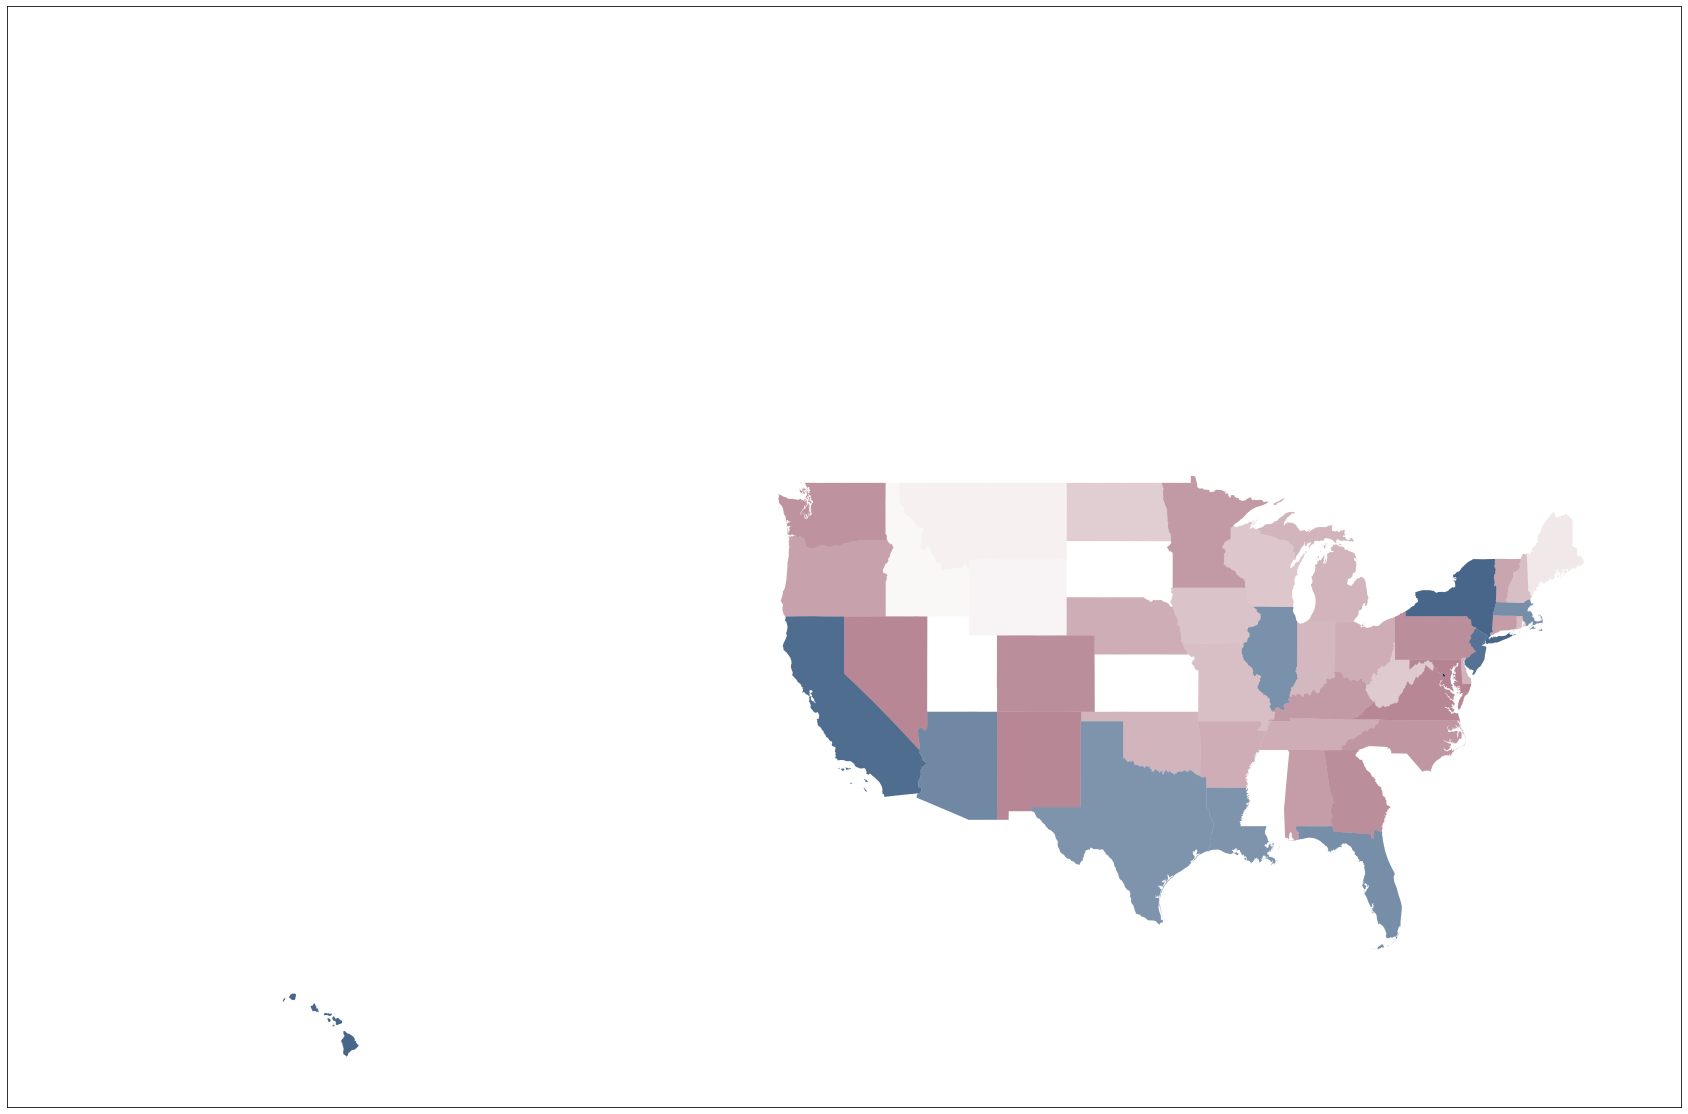

In [29]:
test_dict = plotting_states_continuum(get_mobility_data('2020-06-21', metric='retail_and_recreation_percent_change_from_baseline'))